In [163]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.fft as fft
import scipy.signal as signal

## FFT

In [118]:
# Reload the data
data = pd.read_csv("../Data/1_Stave_supine_static.txt", sep='\t')[1500:-1000].reset_index(drop=True)
data = data.drop(columns=["Log Mode","Log Freq", "Timestamp"])

# PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
pca = PCA()
new_data = pca.fit_transform(scaled_data)
data_pca = pd.DataFrame(new_data[:,0:7])

,0,1,2,3,4,5,6
6665,22.227023,2.018093,-0.613072,-3.016122,-1.019743,2.130194,-0.946239
6666,22.181862,5.042137,-0.654393,-1.917253,0.873967,1.795771,-0.833024
6667,21.996791,4.764660,-1.750168,-1.846827,1.649928,2.032289,-1.781056
6668,-0.049863,4.528703,3.029725,-2.419607,-0.384541,-0.692502,1.758545
6669,-0.432555,1.365812,1.597457,-3.459726,-0.190143,0.961009,1.454359


In [154]:
N = len(data_pca)
acq_freq = 100

# Perform the DFT
sig_fft = fft.fftshift(fft.fft(data_pca, axis=0))
frequencies = fft.fftshift(fft.fftfreq(N, d=1/acq_freq))

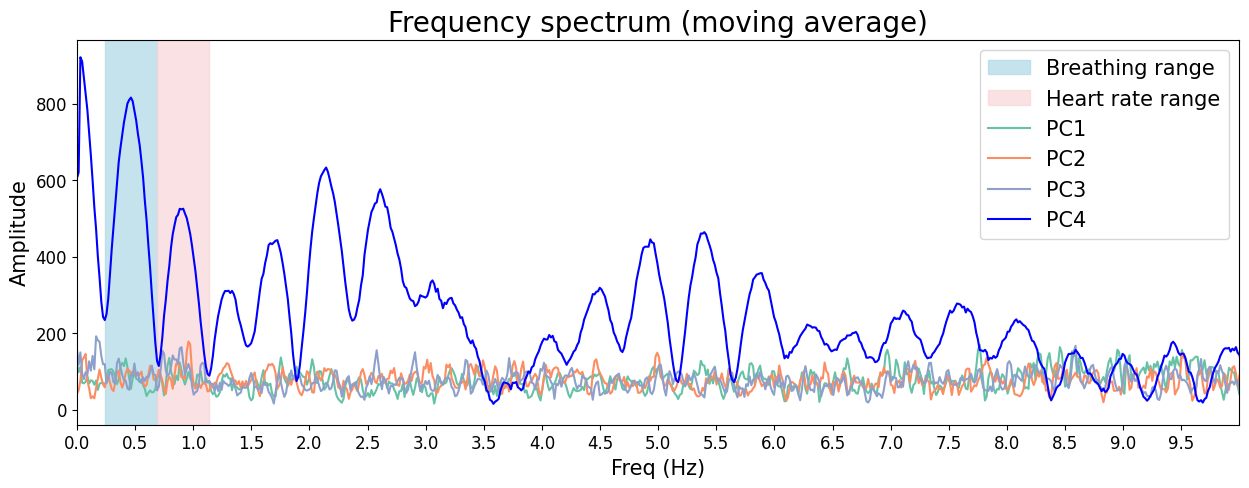

In [222]:
# Find the minima of the spectrum of the fourth principal component
minima, _ = signal.find_peaks(-np.abs(sig_fft[N//2:, 3]))


# Define the moving average (noise reduction)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))

ax.axvspan(frequencies[N//2 + minima[0]], frequencies[N//2 + minima[1]], color="lightblue", alpha=0.7, label="Breathing range")
ax.axvspan(frequencies[N//2 + minima[1]], frequencies[N//2 + minima[4]], color="#F8D5D8", alpha=0.7, label="Heart rate range")

pca_indeces = [0, 1, 2, 3]
palette = ['#66c2a5', '#fc8d62', '#8da0cb', 'blue']
assert len(pca_indeces) == len(palette), "Size error"
for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies[1:-1], moving_average(np.abs(sig_fft[:, i]), 3), color=color, label="PC"+str(i+1))

ax.set_xlim(0, 10)
ax.xaxis.set_ticks(np.arange(0, 10, 0.5))
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Frequency spectrum (moving average)", fontsize=20)
ax.legend(fontsize=15)
#ax.grid('lightgrey')


## 

In [253]:
# Isolate the peak of interest
sig_fft_peak = sig_fft[N//2 + minima[1] : N//2 + minima[4]]
f = frequencies[N//2 + minima[1] : N//2 + minima[4]]

# Antitrasform the data
data_peak = np.fft.ifft(np.fft.ifftshift(sig_fft_peak), axis=0)

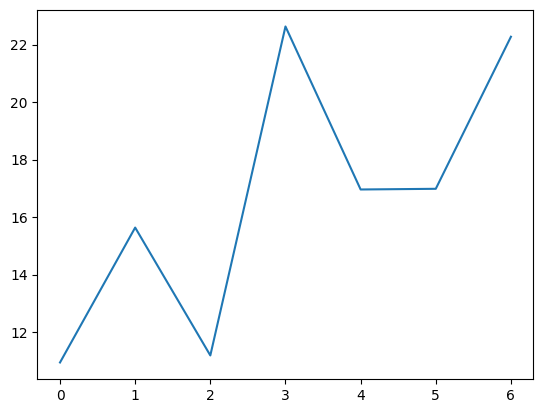

In [254]:
plt.plot(np.abs(data_peak[3]))